In [2]:
from threeML import Powerlaw
from cosipy import FastTSMap, SpacecraftFile
import astropy.units as u
from histpy import Histogram
from astropy.time import Time
import numpy as np
from astropy.coordinates import SkyCoord
from pathlib import Path
from mhealpy import HealpixMap

# Define a powerlaw spectrum

In [3]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

# Read data, background model and orientation

In [8]:
# open bkg model

bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Bkg_2s_model.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

In [9]:
# get orientation
# Note this orientation is hard-coded for this specific GRB

time = Time(np.array([1835481433.0, 1835481433.5, 1835481434.0, 1835481434.5, 1835481435.0]), format="unix")

x_pointings = SkyCoord(b=[53.30823215719789, 53.30823215719789, 53.25629494101732, 53.25629494101732, 53.20436773279772]*u.deg,
                       l = [51.00102125784474, 51.00102125784474, 51.035133117383225, 51.035133117383225, 51.0692916774301]*u.deg,
                       frame = "galactic")

z_pointings = SkyCoord(l = [51.00102125784474, 51.00102125784474, 51.035133117383225, 51.035133117383225, 51.0692916774301]*u.deg, 
                       b = [-36.69176784280211, -36.69176784280211, -36.74370505898268, -36.74370505898268, -36.79563226720228]*u.deg,
                       frame = "galactic")

ori = SpacecraftFile(time = time, x_pointings = x_pointings, z_pointings = z_pointings)

# Start TS map fit

In [10]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/Continuum_Flat_100to10000keV_10logEbins_HealPix03.binnedimaging.imagingresponse_nside8.area.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, frame = "local", scheme = "RING")

In [11]:
# get a list of hypothesis coordinates to fit. The models will be put on these coordinates
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [11]:
# This is the actual parallel fit
# It uses as much as cores available now  ---> Please let me know if it significantly slow down your machine.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING")

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 18.8 µs
The time used for the parallel TS map computation is 3.094292132059733 minutes


# Plot the fitted TS map

In [22]:
ts_array = np.array(ts_results)[:,0:2]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

Text(51, -17, '⬋here lon=51$^\\circ$,lat=-17$^\\circ$')

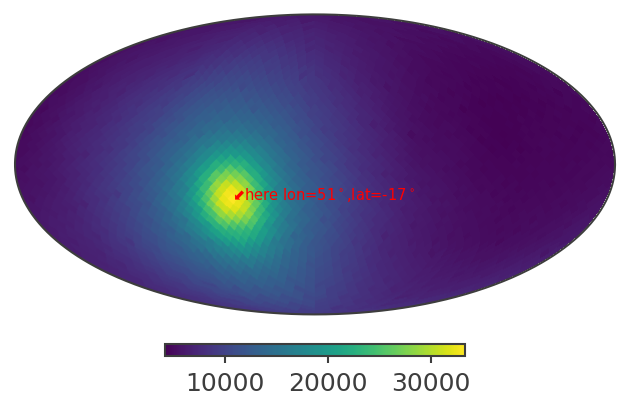

In [23]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, fr"⬋here lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")